In [88]:
import pandas as pd
import numpy as np

import regex as re

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Sklearn imports
from sklearn_pandas import CategoricalImputer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, plot_roc_curve
import shap

# Algorithm imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
import xgboost as xgb

# Imbalanced data
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from datetime import datetime

pd.set_option('display.max_columns', 500)

In [205]:
# PATH = '/Adult \Income \Dataset'

Read metadata file to get column names

In [90]:
# regex pattern for strings not starting with PIPE
filter_ = re.compile('^[^|-].*')

column_names = []
column_desc = []

# read all lines that are not empty 
# and do not start with a PIPE
with open(PATH+'/us_census_full/census_income_metadata.txt') as file:
    lines = [line.strip() for line in file if (line.strip() and filter_.match(line))] 

for line in lines:
    split_ = line.split(': ')
    column_names.append(split_[0])
    column_desc.append(split_[1])
    
column_names = [cn.replace(' ','_') for cn in column_names] 
# .txt says ignore instance weight column for a classifier 

column_desc = [cd.rstrip('.').split(', ') for cd in column_desc]

Read train and test csv with column names from metadata

In [91]:
learn_df = pd.read_csv(PATH+'/census_income_learn.csv', names=column_names+['target'], index_col=False)
test_df = pd.read_csv(PATH+'/census_income_test.csv', names=column_names+['target'], index_col=False)

In [92]:
# we can see that there are no nulls in this dataset
learn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class_of_worker                             199523 non-null  object 
 2   detailed_industry_recode                    199523 non-null  int64  
 3   detailed_occupation_recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage_per_hour                               199523 non-null  int64  
 6   enroll_in_edu_inst_last_wk                  199523 non-null  object 
 7   marital_stat                                199523 non-null  object 
 8   major_industry_code                         199523 non-null  object 
 9   major_occupation_code                       199523 non-null  object 
 

In [93]:
learn_df.head(2)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,instance_weight,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.


In [94]:
# list of continuous, categorical and nominal features

continuous_features = [i for (i,j) in zip(column_names, column_desc) if j[0]=='continuous']
nominal_features = ['detailed_industry_recode', 'detailed_occupation_recode', 'own_business_or_self_employed', 
                    'veterans_benefits', 'year']
categorical_features = [feat for feat in column_names if feat not in continuous_features+nominal_features]

In [95]:
# checking to make sure the values in each column of the dataframe are one of the values in the column description 
for (col, desc) in zip(column_names, column_desc):
    if col not in continuous_features:
        try:
            assert learn_df[learn_df[col].isin(desc)].empty
            assert test_df[test_df[col].isin(desc)].empty
        except:
            print(col)
# These are columns with nominal values

detailed_industry_recode
detailed_occupation_recode
own_business_or_self_employed
veterans_benefits
year


In [96]:
# checking for duplicates
print('Duplicates in training : ', learn_df[learn_df.duplicated(keep='first')].shape[0])
print('Duplcates in test : ', test_df[test_df.duplicated(keep='first')].shape[0])

# drop all these duplicate rows
learn_df.drop_duplicates(keep=False, inplace=True)
test_df.drop_duplicates(keep=False, inplace=True)

Duplicates in training :  3229
Duplcates in test :  883


In [97]:
learn_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [98]:
# transform target column to 0 and 1
# if <50K we have 0 and if >50K we have 1

learn_df['target_updated'] = learn_df.target.apply(lambda x: 0 if x.split()[0]=='-' else 1)
test_df['target_updated'] = test_df.target.apply(lambda x: 0 if x.split()[0]=='-' else 1)

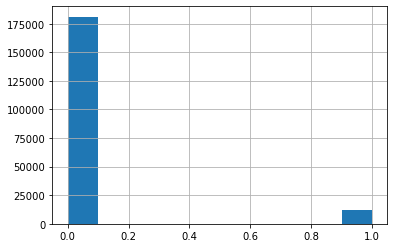

Percentage of 0s (<$50,000): 93.60%


In [99]:
# visualize target variable
fig = learn_df['target_updated'].hist()
plt.show()

print(f"Percentage of 0s (<$50,000): {learn_df[learn_df['target_updated']==0].target_updated.count()/len(learn_df.index):.2%}")

In [100]:
# Imbalanced 

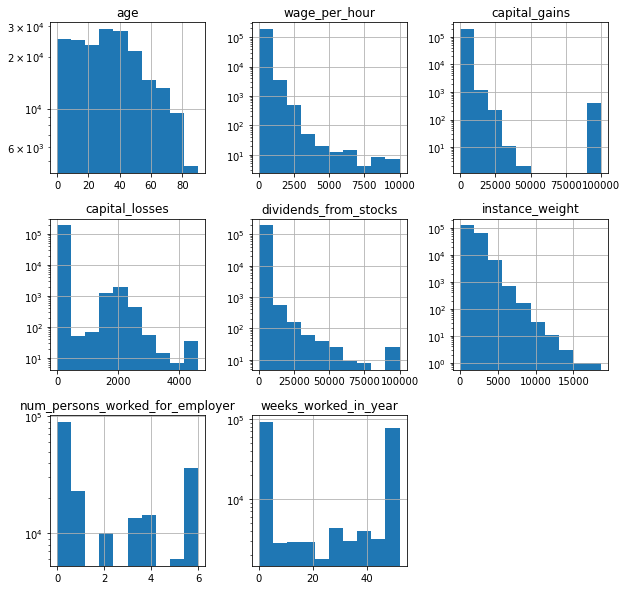

In [101]:
# visualizing continuous variable distributions

fig = learn_df[continuous_features].hist(figsize=[10,10],log='false')
plt.show()

<AxesSubplot:>

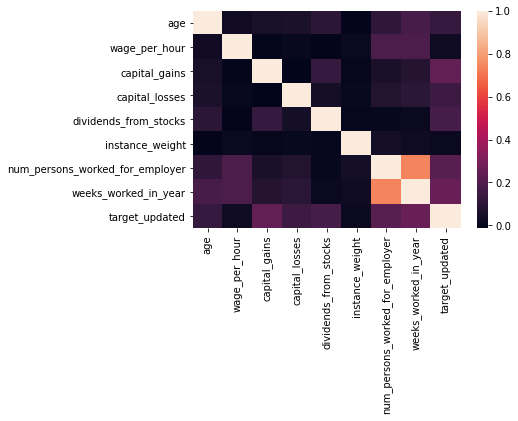

In [102]:
sns.heatmap(learn_df[continuous_features+['target_updated']].corr())

We don't observe any direct correlation of these variables with the target. Maybe another statistical test is needed

In [103]:
# Percentage of 0s in each column
print(learn_df[learn_df == 0.][continuous_features].count(axis=0)/len(learn_df.index))

age                                0.012830
wage_per_hour                      0.941600
capital_gains                      0.961871
capital_losses                     0.979817
dividends_from_stocks              0.890791
instance_weight                    0.000000
num_persons_worked_for_employer    0.465152
weeks_worked_in_year               0.465152
dtype: float64


### Few observations to make about the continuous columns

1. The age of people in this census data is right skewed meaning lot more younger people (0-40 yrs) We can do binnings for this variable like : age_bins = 0-14, 15-25, 25-40, 40-65 and 65+ based on employability and education years etc.(Minimum age to work is 14 and retirement is after 65!)


2. We see features like : capital_gains, capital_losses, dividends_from_stocks, wage_per_hour, weeks_worked_in_a_year, num_persons_worked_for_employer have a lot of zeros. 

Percentage of zeros in these columns :
 
* age                                0.013464
* wage_per_hour                      0.942418
* capital_gains                      0.962408
* capital_losses                     0.980101
* dividends_from_stocks              0.892315
* num_persons_worked_for_employer    0.472607
* weeks_worked_in_year               0.472607


We can create binary features (0 if 0 / 1 if > 0) from variables having a high 0 percentage :
* wage_per_hour_binary
* capital_gains_binary
* capital_losses_binary
* dividends_from_stocks_binary
* num_persons_worked_for_employer_binary
* weeks_worked_in_year_binary


3.  Most people have capital gains <50000 and a few people making 100000

4. Most people have capital losses in the 1500-2500 range.

5.  Maybe we can combine both capital losses and gains and have a net_capital_gain column

6. Dividends from stock is again highly skewed to the right. We can have a net_capital_gain+dividen column

7. num_persons_worked_for_employer usually having someone work for you means a higher paying job so lets bin as 0 and more than 0

8. Wages per hour maybe applicable in only for jobs that pay by the hour

9. Many poeple work more than 50 weeks a year and many work 0 weeks

10. We could create an annual income feature by taking average work hours as 35. Though industry averages vary

`annual_wage = wage_per_hour * 35 (hypothesis of hour per week) * weeks_worked_in_year`


In [104]:
def bin_ages(x):
    if x<15:
        return '0-14'
    if x<25:
        return '15-25'
    if x<40:
        return '26-40'
    if x<66:
        return '41-65'
    return '65+'

In [105]:
# apply age binning
learn_df['age_binned'] = learn_df['age'].apply(lambda x : bin_ages(x))
test_df['age_binned'] = test_df['age'].apply(lambda x : bin_ages(x))

# apply binarization
cols_to_binary = ['wage_per_hour','capital_gains', 'capital_losses', 'dividends_from_stocks',
                  'num_persons_worked_for_employer', 'weeks_worked_in_year']

for col, col_bin in zip(cols_to_binary, [c + '_binary' for c in cols_to_binary]):
    learn_df[col_bin] = learn_df[col].apply(lambda x: 0 if x==0 else 1)
    test_df[col_bin] = test_df[col].apply(lambda x: 0 if x==0 else 1)

# net capital gain
learn_df['net_capital_gain'] = learn_df['capital_gains'] - learn_df['capital_losses']
test_df['net_capital_gain'] = test_df['capital_gains'] - test_df['capital_losses']

# net capital gain + dividend
learn_df['net_capital_dividend'] = learn_df['net_capital_gain'] + learn_df['dividends_from_stocks']
test_df['net_capital_dividend'] = test_df['net_capital_gain'] + test_df['dividends_from_stocks']

# annual wage column assuming a 35 hour week ACROSS industries. This can be modified per industry stats
learn_df['annual_wage'] = learn_df['wage_per_hour'] * 35 * learn_df['weeks_worked_in_year']
test_df['annual_wage'] = test_df['wage_per_hour'] * 35 * test_df['weeks_worked_in_year']

In [106]:
new_continuous_features = ['net_capital_gain', 'net_capital_dividend', 'annual_wage']
new_categorical_features = ['age_binned']
new_binary_features = [c + '_binary' for c in cols_to_binary]

cols_to_drop = ['capital_losses', 'capital_gains',
               'age', 
               ]


In [107]:
print('Nominal Features count : ', len(nominal_features), 
      '\nCategorical Features count : ', len(categorical_features))

Nominal Features count :  5 
Categorical Features count :  28


In [108]:
# learn_df[nominal_features] = learn_df[nominal_features].astype('category')
# learn_df[categorical_features] = learn_df[categorical_features].astype('category')

					NOMINAL COLUMNS


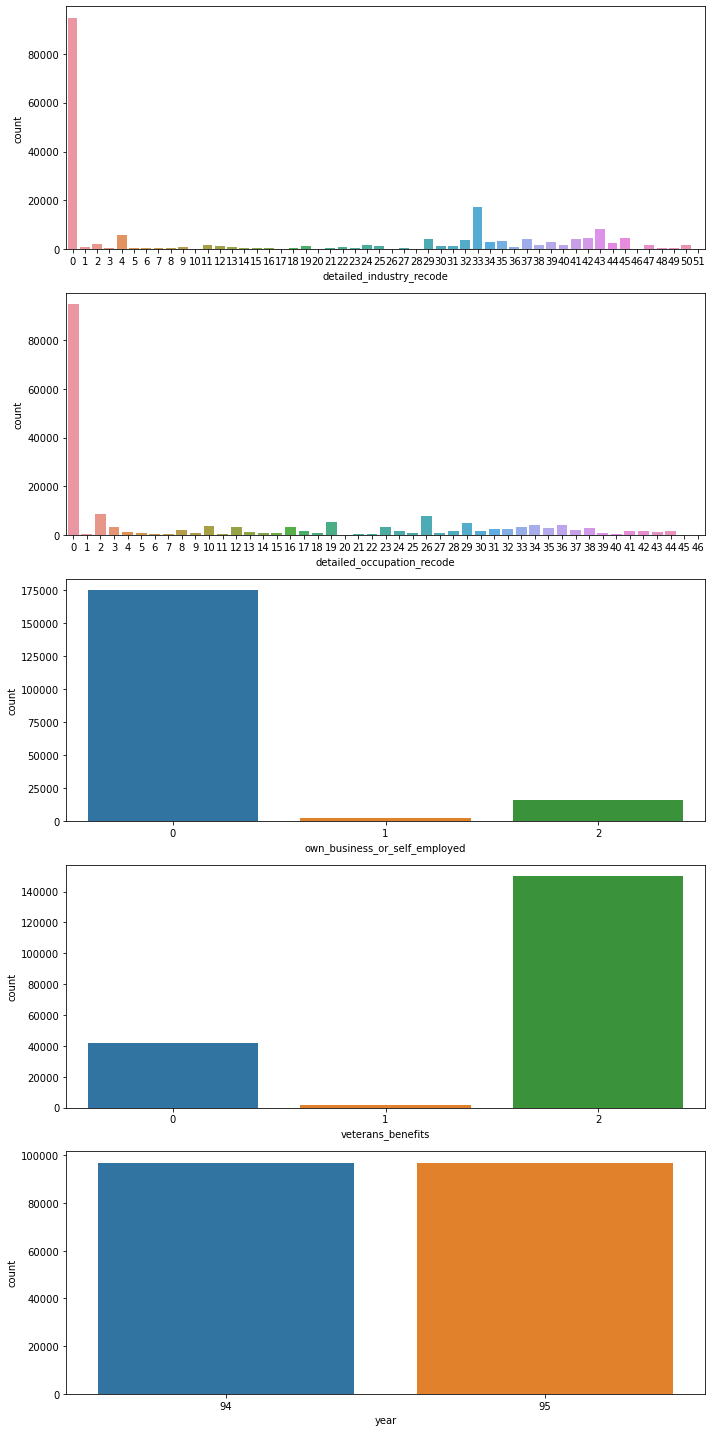

In [109]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
axes = axes.flatten()

print('\t\t\t\t\tNOMINAL COLUMNS')

for ax, y in zip(axes, nominal_features):
    sns.countplot(y, data=learn_df, ax=ax)

plt.tight_layout()  
plt.show()

### Few observations about the nominal columns

1. We could choose to leave these columns as they are. But since they are numerically encoded, and there is no ordinality some algorithms that use Euclidean distance
maybe sensitive >>> Find alternative encoding but it's a GOOD TO HAVE FEATURE. Not essential

2. We get more information on these variabels at https://www.ilo.org/surveyLib/index.php/catalog/2698/search?vk=detailed+industry+recode
  
3. Some of the most frequent detailed_industry_recode : 
    - 0 is not available, 
    - 33 : eating and drinking places, 
    - 43 : non-hospital health places,
    - 4 : Construction
  
4. Some of the most frequent detailed_occupation_recode : 
    - 2 : OTHER EXECUTIVE, ADMIN. & MANAGERIAL, 
    - 26 : OTHER ADMIN. SUPPORT, INCLUDING CLERICAL, 
    - 19 : SALES WORKERS, RETAIL & PERSONAL SERVICES, 
    - 29 : FOOD SERVICE

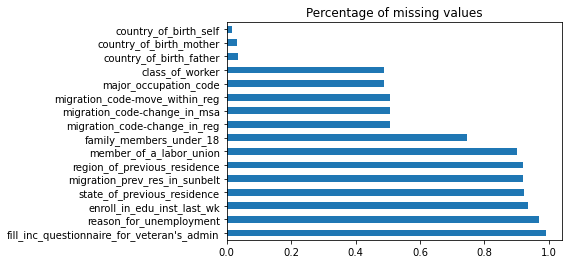

In [110]:
# For categorical variables the column values 'Not in universe' and '?' are missing values
for col in categorical_features: 
    learn_df[col] = learn_df[col].apply(lambda x: str(x).strip())
    
percent = (learn_df.isin(['Not in universe', '?']).sum()/len(learn_df.index)).sort_values(ascending=False)
fig = percent.head(16).plot(kind='barh',title='Percentage of missing values')
plt.show()

In [111]:
# We can do imputations on cols with missing values using mode and 
# drop columns with huge percentage of missing values >75-80%
# some columns maybe applicable in certain scenarios only
cols_to_drop += ["fill_inc_questionnaire_for_veteran's_admin", 
                "reason_for_unemployment", 
                "enroll_in_edu_inst_last_wk",
                "state_of_previous_residence",
                "region_of_previous_residence",
                "instance_weight",
                "member_of_a_labor_union",
                "family_members_under_18",
                "target"]

# do a simple imputation to replace all missing values with another new value 'Other_Unknown'
learn_df = learn_df.replace('Not in universe', 'Other_Unknown')
learn_df = learn_df.replace('?', 'Other_Unknown')
learn_df = learn_df.replace('Not in universe under 1 year old', 'Other_Unknown')

test_df = test_df.replace('Not in universe', 'Other_Unknown')
test_df = test_df.replace('?', 'Other_Unknown')
test_df = test_df.replace('Not in universe under 1 year old', 'Other_Unknown')

					Categorical Features


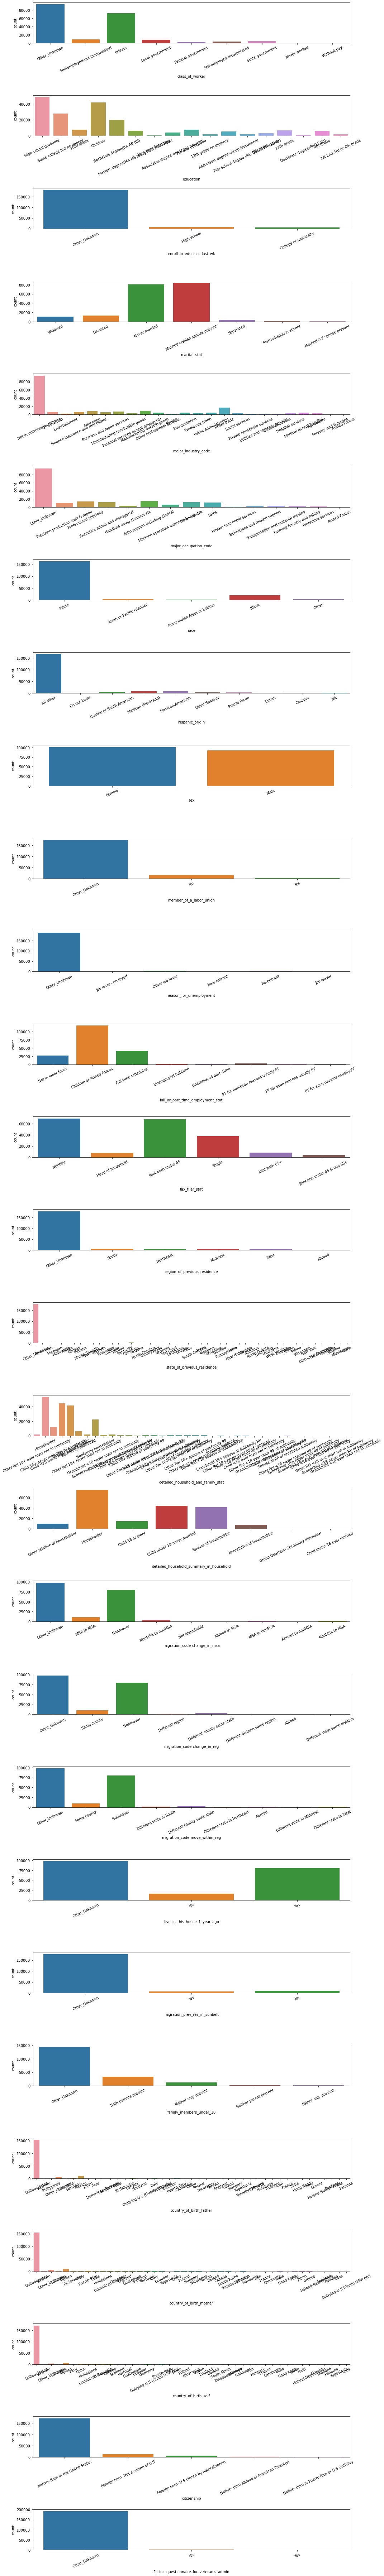

In [112]:
fig, axes = plt.subplots(28, 1, figsize=(15, 100))
axes = axes.flatten()

print('\t\t\t\t\tCategorical Features')

for ax, y in zip(axes, categorical_features):
    plt.setp(ax.get_xticklabels(), rotation=25)
    sns.countplot(y, data=learn_df, ax=ax)

plt.tight_layout()  
plt.show()

### Looking at these categorical plots we can make a observations on a few columns

1. class_of_worker : We have several people in the Private sector and few government 

2. education : We have several different levels here. Most are High School graduates and children. 
Maybe we can do a Masters / Bachelor, High School, Pre-High
School, rest

3. marital_status : we have different levels in this but can group as single or married maybe

4. major_industry_code : we can group private sector etc but this is a GOOD TO HAVE

5. major_occupation_code : same as above

6. tax_filer_stat : we can group as filer vs non-filer

7. detailed_household_summary_in_household : we can group as householder and not a householder

8. All the migration_code columns can be grouped as mover and non-mover

In [113]:
# we create features from education
education_mid = ['High school graduate', 'Associates degree-occup /vocational', 'Some college but no degree']

education_high = ['Masters degree(MA MS MEng MEd MSW MBA)', 'Prof school degree (MD DDS DVM LLB JD)', 
                  'Doctorate degree(PhD EdD)', 'Bachelors degree(BA AB BS)', 'Associates degree-academic program']

education_low = ['7th and 8th grade', 'Less than 1st grade', '10th grade', '9th grade', 'Children', 
                 '12th grade no diploma', '5th or 6th grade', '11th grade', '1st 2nd 3rd or 4th grade']

def recode_education(x):
    if x in education_high:
        return 2
    if x in education_mid:
        return 1
    return 0

learn_df['education_recoded'] = learn_df['education'].apply(lambda x: recode_education(x))
learn_df['education_advanced'] = learn_df['education'].apply(lambda x: 1 if x in education_high else 0)

test_df['education_recoded'] = test_df['education'].apply(lambda x: recode_education(x))
test_df['education_advanced'] = test_df['education'].apply(lambda x: 1 if x in education_high else 0)



# marital status 1 if married else 0
married_stat = ['Married-civilian spouse present', 'Married-A F spouse present', 'Married-spouse absent']

learn_df['marital_stat_binary'] = learn_df['marital_stat'].apply(lambda x: 1 if x in married_stat else 0)
test_df['marital_stat_binary'] = test_df['marital_stat'].apply(lambda x: 1 if x in married_stat else 0)

# tax_filer_binary = 1 if files tax else 0
learn_df['tax_filer_binary'] = learn_df['tax_filer_stat'].apply(lambda x: 0 if x in ['Nonfiler'] else 1)
test_df['tax_filer_binary'] = test_df['tax_filer_stat'].apply(lambda x: 0 if x in ['Nonfiler'] else 1)

# householder_binary = 1 if householder else 0
learn_df['householder_binary'] = (learn_df['detailed_household_summary_in_household']
                                  .apply(lambda x: 1 if x in ['Householder'] else 0))
test_df['householder_binary'] = (test_df['detailed_household_summary_in_household']
                                  .apply(lambda x: 1 if x in ['Householder'] else 0))

In [114]:
new_binary_features += ['education_advanced', 'marital_stat_binary', 'tax_filer_binary', 'householder_binary']
new_categorical_features += ['education_recoded']

In [115]:
# list of columns :
# continuous_features
# categorical_features
# nominal_features

# new_continuous_features
# new_categorical_features
# new_binary_features

In [116]:
# Transformation functions

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from collections import defaultdict

# this dictionary keeps all categorical encoders. Use it for inverse transformations later on
encoder_dict = defaultdict(LabelEncoder)

def transform_continuous_columns(df):
    features = df[continuous_features+new_continuous_features]
    scaler = MinMaxScaler().fit(features.values)
    features = scaler.transform(features.values)

    df[continuous_features+new_continuous_features] = features
    return df

def fit_categorical_transformer(learn_df, test_df):
    df_joined = learn_df.append(test_df, ignore_index=True)
    for col in categorical_features+new_categorical_features:
        encoder_dict[col].fit(df_joined[col])

def transform_categorical_columns(df):
    # Encoding the variable
    df[categorical_features+new_categorical_features] = (df[categorical_features+new_categorical_features]
                                                         .apply(lambda x: encoder_dict[x.name].transform(x)))
    return df

def inverse_transform_categorical(df):
    df[categorical_features+new_categorical_features] = (df[categorical_features+new_categorical_features]
                                                         .apply(lambda x: encoder_dict[x.name].inverse_transform(x)))
    return df

In [117]:
learn_df = transform_continuous_columns(learn_df)
test_df = transform_continuous_columns(test_df)

In [118]:
fit_categorical_transformer(learn_df, test_df)

In [119]:
learn_df = transform_categorical_columns(learn_df)
test_df = transform_categorical_columns(test_df)

In [120]:
learn_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)

In [121]:
target_column = 'target_updated'
feature_columns = [i for i in learn_df.columns if i not in [target_column]]

In [122]:
# Prepare Final DataFrames

X = learn_df[feature_columns]
y = learn_df[target_column]

X_test = test_df[feature_columns]
y_test = test_df[target_column]

In [38]:
print(X.shape, y.shape, X_test.shape, y_test.shape)

(193528, 46) (193528,) (98076, 46) (98076,)


In [56]:
# scale all features
scaler_ = MinMaxScaler()
X_scaled = scaler_.fit_transform(X)

In [133]:
X.dtypes.value_counts()

int64      38
float64     7
dtype: int64

### TRAIN MODELS WITH DEFAULT HYPERPARAMETERS

Model Comparison using a simple train test split for validation

In [57]:
# Train Validation Split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

1. Logistic Regression

In [58]:
# Create a baseline model using Logistic Regression
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_classifier.predict_proba(X_val)
# predict classes
lr_preds_target = lr_classifier.predict(X_val)

lr_fpr, lr_tpr, lr_threshold = roc_curve(y_val, lr_probs[:,1])
lr_classification_report = classification_report(y_val, lr_preds_target)

/Users/sandeep/anaconda3/envs/crp-tf-1.15/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [59]:
lr_precision, lr_recall, lr_pr_threshold = precision_recall_curve(y_val, lr_probs[:,1])

In [60]:
print(lr_classification_report)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     36196
           1       0.64      0.27      0.38      2510

    accuracy                           0.94     38706
   macro avg       0.79      0.63      0.67     38706
weighted avg       0.93      0.94      0.93     38706



2. Random Forest Model

In [61]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

rf_probs = rf_classifier.predict_proba(X_val)

rf_preds_target = rf_classifier.predict(X_val)

rf_fpr, rf_tpr, rf_threshold = roc_curve(y_val, rf_probs[:,1])
rf_classification_report = classification_report(y_val, rf_preds_target)

In [62]:
rf_precision, rf_recall, rf_pr_threshold = precision_recall_curve(y_val, rf_probs[:,1])

In [63]:
print(rf_classification_report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     36196
           1       0.69      0.43      0.53      2510

    accuracy                           0.95     38706
   macro avg       0.83      0.71      0.75     38706
weighted avg       0.94      0.95      0.95     38706



3. xgboost

In [64]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)

xgb_probs = xgb_classifier.predict_proba(X_val)

xgb_preds_target = xgb_classifier.predict(X_val)

xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_val, xgb_probs[:,1])
xgb_classification_report = classification_report(y_val, xgb_preds_target)

In [65]:
xgb_precision, xgb_recall, xgb_pr_threshold = precision_recall_curve(y_val, xgb_probs[:,1])

In [66]:
print(xgb_classification_report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     36196
           1       0.76      0.37      0.49      2510

    accuracy                           0.95     38706
   macro avg       0.86      0.68      0.73     38706
weighted avg       0.94      0.95      0.94     38706



4. Catboost

In [67]:
catboost_classifier = CatBoostClassifier()
# Fit model
catboost_classifier.fit(X_train, y_train, silent=True)

In [68]:
catboost_probs = catboost_classifier.predict_proba(X_val)

catboost_preds_target = catboost_classifier.predict(X_val)

catboost_fpr, catboost_tpr, catboost_threshold = roc_curve(y_val, catboost_probs[:,1])
catboost_precision, catboost_recall, catboost_pr_threshold = precision_recall_curve(y_val, catboost_probs[:,1])

catboost_classification_report = classification_report(y_val, catboost_preds_target)

In [69]:
print(catboost_classification_report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     36196
           1       0.75      0.47      0.58      2510

    accuracy                           0.96     38706
   macro avg       0.86      0.73      0.78     38706
weighted avg       0.95      0.96      0.95     38706



In [70]:
fscore = (2 * catboost_precision * catboost_recall) / (catboost_precision + catboost_recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (catboost_pr_threshold[ix], fscore[ix]))

Best Threshold=0.294054, F-Score=0.613


### To compare models, using just the accuracy score is NOT enough. 

Especially in a case of Imbalanced Datasets like ours. We use a **Precision and Recall** Scores along with the PR AUC to choose the best model so far. There is also an ROC vs PR call we should make. Let us plot both curves for all these models

From the classification reports we can see that **CatBoost is the best performing** followed by Xgb and RandomForest. Logistic Regression is the worst of all.

In [71]:
models = ['LR','RF','XGB','CATBOOST']

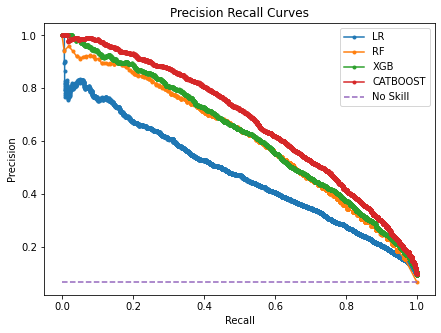

In [72]:
# plot the PR curve because the dataset is quite imbalanced

precisions = [lr_precision, rf_precision, xgb_precision, catboost_precision]
recalls = [lr_recall, rf_recall, xgb_recall, catboost_recall]

plt.figure(figsize=(7,5))
plt.title('Precision Recall Curves')

for precision, recall, model in zip(precisions, recalls, models):
    plt.plot(recall, precision, marker='.', label=model)

no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Text(0.5, 0, 'False Positive Rate')

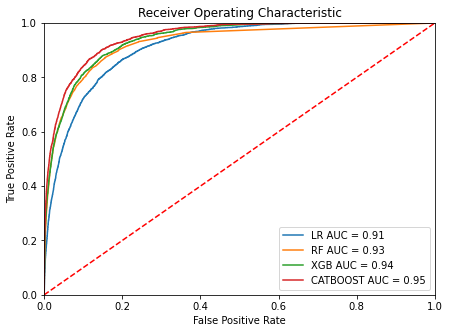

In [73]:
# Let us compare ROC for the models as well

fprs = [lr_fpr, rf_fpr, xgb_fpr, catboost_fpr]
tprs = [lr_tpr, rf_tpr, xgb_tpr, catboost_tpr]
roc_aucs = [auc(f,t) for f,t in zip(fprs, tprs)]

plt.figure(figsize=(7,5))
plt.title('Receiver Operating Characteristic')


for fpr, tpr, roc_auc, model in zip(fprs, tprs, roc_aucs, models):
    plt.plot(fpr, tpr, label = model+' AUC = %0.2f' % roc_auc)
    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

After observing the ROC and PR curves we can confirm our initial observation and choose Catboost Model for further analysis

### Parameter Tuning

We do a grid search to find the best parameters that do not overfit the model

1. class_weights
2. depth 
3. learning_rate
4. l2_lead_reg

In [95]:
model = CatBoostClassifier(silent=True)

cv = StratifiedKFold(n_splits=5)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
#         'class_weights': [[x, 1.0-x] for x in np.linspace(0,0.99,7)]
       }

grid_search_result = model.grid_search(grid, 
                                       X=X, 
                                       y=y,
                                       cv=cv,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.120781047
bestIteration = 999

0:	loss: 0.1207810	best: 0.1207810 (0)	total: 34.3s	remaining: 16m 34s

bestTest = 0.1172085795
bestIteration = 999

1:	loss: 0.1172086	best: 0.1172086 (1)	total: 1m 8s	remaining: 15m 59s

bestTest = 0.1208817448
bestIteration = 999

2:	loss: 0.1208817	best: 0.1172086 (1)	total: 1m 44s	remaining: 15m 41s

bestTest = 0.1174769828
bestIteration = 996

3:	loss: 0.1174770	best: 0.1172086 (1)	total: 2m 18s	remaining: 15m 2s

bestTest = 0.1211014225
bestIteration = 999

4:	loss: 0.1211014	best: 0.1172086 (1)	total: 2m 53s	remaining: 14m 27s

bestTest = 0.1170604005
bestIteration = 999

5:	loss: 0.1170604	best: 0.1170604 (5)	total: 3m 28s	remaining: 13m 54s

bestTest = 0.1210497682
bestIteration = 999

6:	loss: 0.1210498	best: 0.1170604 (5)	total: 4m 3s	remaining: 13m 19s

bestTest = 0.117409531
bestIteration = 997

7:	loss: 0.1174095	best: 0.1170604 (5)	total: 4m 40s	remaining: 12m 51s

bestTest = 0.1211285807
bestIteration = 999

8:	loss: 0.12112

### NEXT STEPS
I will be doing these before submitting

In [75]:
# Correlation plots?
# 1. Dealing with Imbalanced class : SMOTE (OR) 
# Weighted Log Loss for classes during training (Seems to give bad result using scale_pos_weight)
# 2. Choose Best model for HYPERPARAMETER Tuning
# 3. Cross Validation on the best model to get ROCAUC Precision Recall Scores
# 4. Predict on TEST Data (have not used it yet) and report Scores of Precision, Recall, F1 and Accuracy
# 5. IMPORTANT : Dependancy Plot and SHAP values for model interpretability and Making the PPT

In [101]:
grid_search_result['params']

{'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

In [88]:
# {'silent': True, 'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.1}

### Cross Validation with Best Parameters

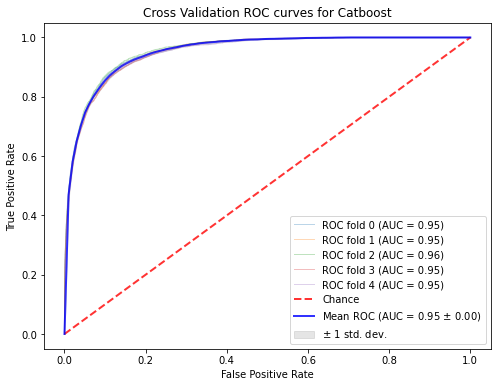

In [98]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)

model = CatBoostClassifier(silent=True, depth=6, l2_leaf_reg=5, learning_rate=0.1)

classifier = model

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8,6))
for i, (train, test) in enumerate(cv.split(X, y)):
    model.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(model, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Cross Validation ROC curves for Catboost")
ax.legend(loc="lower right")
plt.show()

In [100]:
model.get_params()

{'silent': True, 'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

### Prediction on test data

In [135]:
# model.fit(X, y)

In [136]:
# results on Test
preds_test = model.predict(X_test)

tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, preds_test).ravel()
precision_test = tp_test/(tp_test+fp_test)
recall_test = tp_test/(tp_test+fn_test)
f1_test = 2*(recall_test * precision_test)/(recall_test + precision_test)

In [137]:
preds_proba = model.predict_proba(X_test)[:,1]

model_classification_report = classification_report(y_test, preds_test)

In [138]:
print(model_classification_report)


#               precision    recall  f1-score   support

#            0       0.95      0.99      0.97     91890
#            1       0.73      0.28      0.41      6186

#     accuracy                           0.95     98076
#    macro avg       0.84      0.64      0.69     98076
# weighted avg       0.94      0.95      0.94     98076

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     91890
           1       0.73      0.28      0.41      6186

    accuracy                           0.95     98076
   macro avg       0.84      0.64      0.69     98076
weighted avg       0.94      0.95      0.94     98076



In [210]:
# Test ROC AUC = 0.90

### Model Interpretation

In [139]:
shap.initjs()

In [140]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X, y)

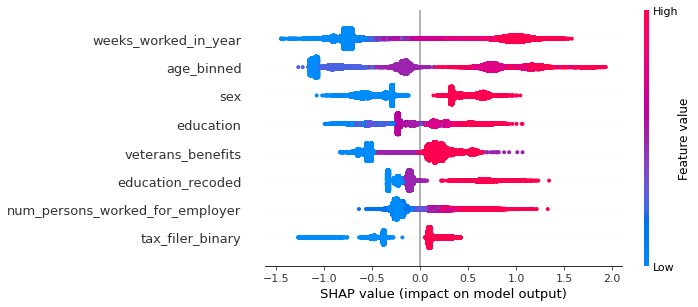

In [142]:
shap.summary_plot(shap_values, X, max_display=8)

The features are in order of importance. A few comments here (More details in the presentation)

1. Higher values of Weeks worked in a year can have a positive effect on SHAP values (contributes to a prediction of >$50,000)

2. Higher Age Group people tend to be associated to the >$50,000 group

3. Being a male has a positive effect on SHAP values as well an so does being highly educated and being a tax filer. education_recoded has 0, 1 and 2 -> below high school, high school graduate and advanced education.

### Partial Dependency Plots

Observations for these plots in the PPT

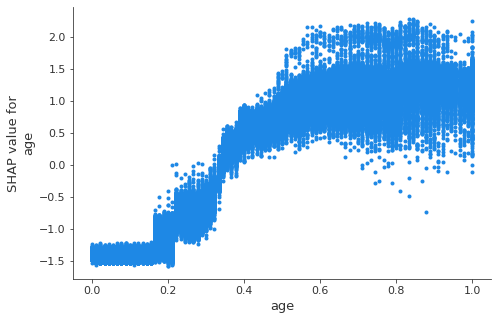

In [76]:
shap.dependence_plot('age', shap_values, X, interaction_index=None)

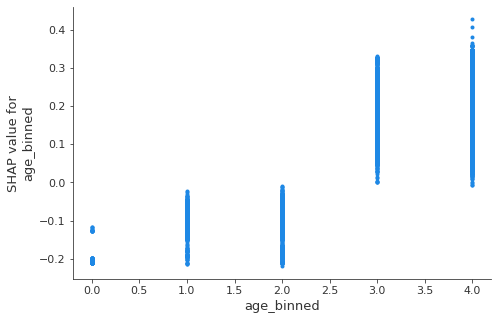

In [66]:
shap.dependence_plot('age_binned', shap_values, X, interaction_index=None)

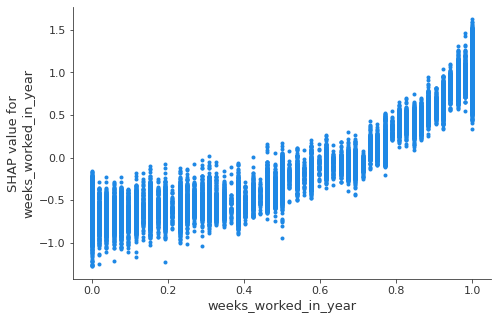

In [67]:
shap.dependence_plot('weeks_worked_in_year', shap_values, X, interaction_index=None)

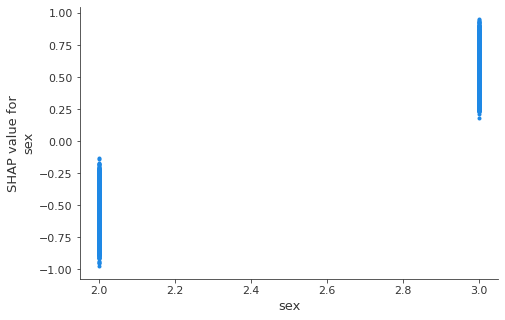

In [68]:
shap.dependence_plot('sex', shap_values, X, interaction_index=None)

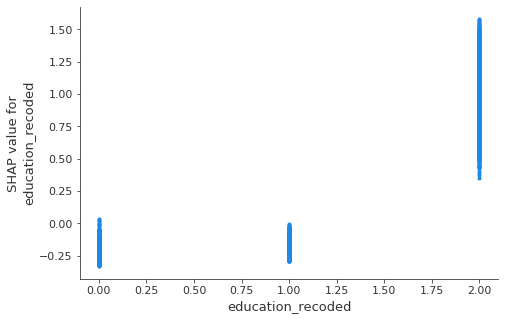

In [81]:
shap.dependence_plot('education_recoded', shap_values, X, interaction_index=None)

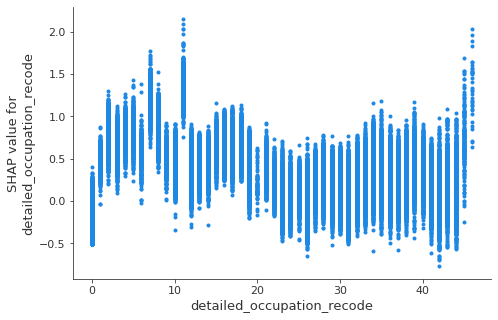

In [83]:
shap.dependence_plot('detailed_occupation_recode', shap_values, X, interaction_index=None)

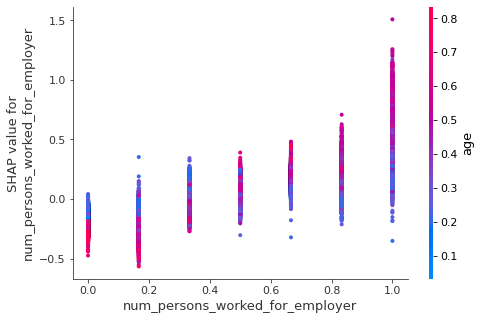

In [60]:
shap.dependence_plot('num_persons_worked_for_employer', shap_values, X)

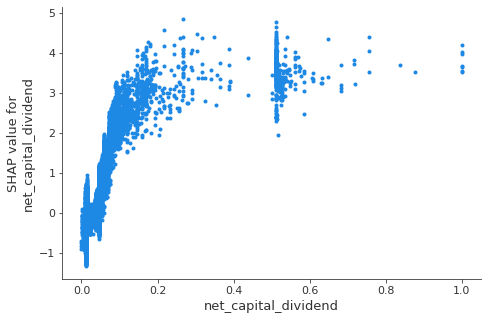

In [87]:
shap.dependence_plot('net_capital_dividend', shap_values, X, interaction_index=None)

 Feature Contributions for a record with prediction as <$50,000

In [200]:
shap.force_plot(explainer.expected_value, shap_values[100], X.iloc[[100]])

 Feature Contributions for a record with prediction as >$50,000

In [203]:
shap.force_plot(explainer.expected_value, shap_values[190], X.iloc[[190]])

# END 

### Extra Work
Experimenting Data Sampling

In [ ]:
# sampled_df = pd.read_csv(PATH+'/us_census_full/census_income_learn.csv', names=column_names+['target'], index_col=False)

<AxesSubplot:xlabel='target', ylabel='age'>

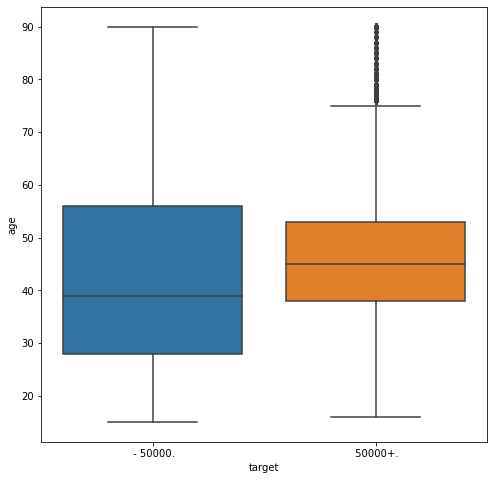

In [195]:
# fig, ax = plt.subplots(figsize=(8,8))
# sns.boxplot(x=sampled_df[sampled_df['age']>14]['target'], y=sampled_df[sampled_df['age']>14]['age'], orient='v', ax=ax)

<AxesSubplot:xlabel='target', ylabel='weeks_worked_in_year'>

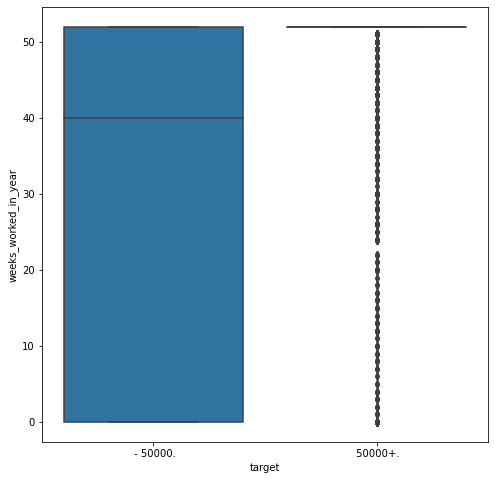

In [193]:
# fig, ax = plt.subplots(figsize=(8,8))
# sns.boxplot(x=sampled_df[sampled_df['age']>14]['target'], y=sampled_df[sampled_df['age']>14]['weeks_worked_in_year'], orient='v', ax=ax)

In [ ]:
# Sampling

In [ ]:
# under_sampler = RandomUnderSampler(sampling_strategy=1)
# X_sampled, y_sampled = under_sampler.fit_sample(X, pd.DataFrame(y))

# print('Number of 1s in sampled training : ', (y_sampled['target_updated']==1).sum(), 
#       '\nNumber of 0s in sampled training : ',(y_sampled['target_updated']==0).sum())


# # model with Downsampling Majority Class
# model_sampled = xgb.XGBClassifier(silent=True)

# # define cross-validation with Stratified Sampling to maintain same ratio between the two classes
# stratified_cv = StratifiedKFold(n_splits=5)

# # evaluate model
# scores_sampled = cross_validate(model_sampled, X_sampled, y_sampled, 
#                                 scoring=['roc_auc', 'f1', 'precision', 'recall'], cv=stratified_cv)

# # summarize performance
# print('F1 scores \t', scores_sampled['test_f1'], '\nROC AUC scores \t', scores_sampled['test_roc_auc'],
#      '\nPrecision Scores', scores_sampled['test_precision'], '\nRecall Scores \t', scores_sampled['test_recall'])

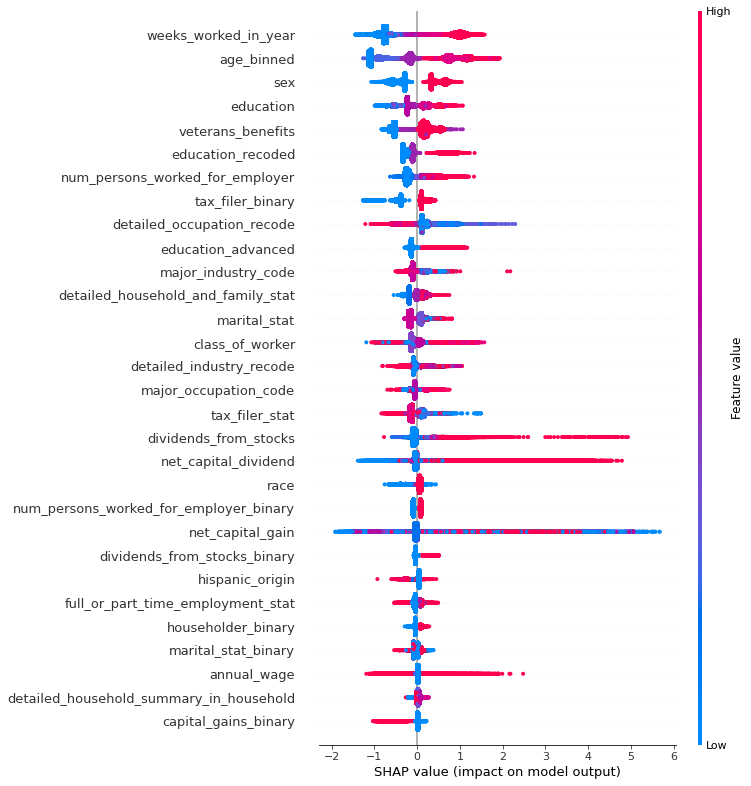

In [141]:
# shap.summary_plot(shap_values, X, max_display=30)